## Project Details


## Import Packages

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Data Descriptions

• Customer table used to only keep real customers. For example, test accounts are removed from the data.

• Visit Plans History table gives us the most recent visit plan for each timestamp. This tells us the customer’s anchor date and frequency.

• Orders table is used to check the orders in GA data against what was actually ordered.

• Sales table is used to see what was actually sold to customers. This is different than the orders table due to some items sometimes being sold out.

• Cutoff table - Each customer has a specific time of day they are supposed to order by. This time is generally 5pm but the Cutoff times table gives us the exceptions.

• Operating hours table gives us the current frequency, anchor day, and anchor date for each customer. The visit plans table is a historical version of this table.

• Material table gives us descriptive information for each material id. Such as size, category and brand.


## Rules & Calculations

• Anchor Date, cutoff time from each plant / sales office, and frequency are used to
compute when the customer is supposed to order next for each event in the GA data.
The most recent anchor date and frequency are retrieved from the visit plans history
table. These with the cutoff time give when the exact time and day when a customer is
expected to order by.

• The time between two expected order by times is called an “Order Window”.

• All timestamps in Google Analytics are logged in EST, but the cutoff times are local to the customer. An
adjusted timestamp column must be computed using the time zone of the sales office
that customer orders from.

## Import Data

### Cutoff Times

In [3]:
# Loading Cutoff Times Data

# Time of day customers must have their orders in by, by sales office
#     SALES_OFFICE - which sales office the customer orders from
#     PLANT_ID - which bottling plant the customer receives their order from
#     CUTOFFTIME_C - time the customer must have their order in. If NA then time is 5pm
#     SHIPPING_CONDITION_TIME - general shipping strategy for delivery of goods
#     DISTRIBUTION_MODE - mode of distrobution for a customer.

cutoff = pd.read_csv("cutoff_times.csv")

# Should have 220 rows and 5 columns

print(cutoff.shape)

(220, 5)


In [4]:
# head
print(cutoff.head())

  SALES_OFFICE PLANT_ID CUTOFFTIME__C SHIPPING_CONDITION_TIME  \
0   Draper, UT     G111    6:00:00 PM                   72hrs   
1   Draper, UT     G111    6:00:00 PM                   48hrs   
2   Draper, UT     G111    1:30:00 PM                   24hrs   
3   Draper, UT     G111    3:30:00 PM                   24hrs   
4   Draper, UT     G111    3:30:00 PM                   24hrs   

   DISTRIBUTION_MODE  
0          Tell Sell  
1          Tell Sell  
2          Tell Sell  
3                OFS  
4  Bulk Distribution  


In [5]:
# Cutoff Times Summary Stats
print(cutoff.isna().sum())
print(cutoff.info())
print(cutoff.describe(include="all"))

SALES_OFFICE               0
PLANT_ID                   0
CUTOFFTIME__C              0
SHIPPING_CONDITION_TIME    0
DISTRIBUTION_MODE          0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220 entries, 0 to 219
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   SALES_OFFICE             220 non-null    object
 1   PLANT_ID                 220 non-null    object
 2   CUTOFFTIME__C            220 non-null    object
 3   SHIPPING_CONDITION_TIME  220 non-null    object
 4   DISTRIBUTION_MODE        220 non-null    object
dtypes: object(5)
memory usage: 8.7+ KB
None
       SALES_OFFICE PLANT_ID CUTOFFTIME__C SHIPPING_CONDITION_TIME  \
count           220      220           220                     220   
unique           43       43            17                       3   
top       Tempe, AZ     G261    3:00:00 PM                   24hrs   
freq             12       12            36

In [6]:
# Converting cutoff times:
cutoff["CUTOFFTIME__C"] = cutoff["CUTOFFTIME__C"].fillna("5:00:00 PM")
cutoff["CUTOFFTIME__C"] = pd.to_datetime(cutoff["CUTOFFTIME__C"], format="%I:%M:%S %p")
cutoff["CUTOFFTIME__C"].dtypes

dtype('<M8[ns]')

In [7]:
# finding unique sales offices
unique_offices = cutoff["SALES_OFFICE"].unique()
print(unique_offices)

['Draper, UT' 'Logan, UT' 'Richfield, UT' 'Price, UT' 'Ogden, UT'
 'Grand Junction, CO' 'Alamosa, CO' 'Glenwood, CO' 'Idaho Falls, ID'
 'Pocatello, ID' 'Boise, ID' 'Twin Falls, ID' 'Scottsbluff, NE'
 'Cheyenne, WY' 'Flagstaff, AZ' 'Kingman, AZ' 'Show Low, AZ' 'Chinle, AZ'
 'Reno, NV' 'Elko, NV' 'Walla Walla, WA' 'LaGrande, OR' 'Pendleton, OR'
 'Lewiston, ID' 'Wilsonville, OR' 'Bend, OR' 'Eugene, OR' 'Johnstown, CO'
 'Denver, CO' 'Pueblo, CO' 'Colorado Springs, CO' 'Tempe, AZ'
 'Glendale, AZ' 'Prescott, AZ' 'Cochise, AZ' 'Tucson, AZ' '0'
 'Albuquerque, NM' 'Wenatchee, WA' 'Bellevue, WA' 'Bremerton, WA'
 'South Sound, WA' 'Arlington, WA']


In [8]:
tz_map = {
    # Utah ~ Mountain
    "Draper, UT": "America/Denver",
    "Logan, UT": "America/Denver",
    "Richfield, UT": "America/Denver",
    "Price, UT": "America/Denver",
    "Ogden, UT": "America/Denver",

    # Colorado ~ Mountain
    "Grand Junction, CO": "America/Denver",
    "Alamosa, CO": "America/Denver",
    "Glenwood, CO": "America/Denver",
    "Johnstown, CO": "America/Denver",
    "Denver, CO": "America/Denver",
    "Pueblo, CO": "America/Denver",
    "Colorado Springs, CO": "America/Denver",

    # Idaho ~ mostly Mountain, except Lewiston → Pacific
    "Idaho Falls, ID": "America/Denver",
    "Pocatello, ID": "America/Denver",
    "Boise, ID": "America/Denver",
    "Twin Falls, ID": "America/Denver",
    "Lewiston, ID": "America/Los_Angeles",

    # Nebraska ~ Central
    "Scottsbluff, NE": "America/Chicago",

    # Wyoming ~ Mountain
    "Cheyenne, WY": "America/Denver",

    # Arizona ~ Mountain (no DST)
    "Flagstaff, AZ": "America/Phoenix",
    "Kingman, AZ": "America/Phoenix",
    "Show Low, AZ": "America/Phoenix",
    "Chinle, AZ": "America/Phoenix",
    "Tempe, AZ": "America/Phoenix",
    "Glendale, AZ": "America/Phoenix",
    "Prescott, AZ": "America/Phoenix",
    "Cochise, AZ": "America/Phoenix",
    "Tucson, AZ": "America/Phoenix",

    # Nevada ~ Pacific
    "Reno, NV": "America/Los_Angeles",
    "Elko, NV": "America/Los_Angeles",

    # Washington ~ Pacific
    "Walla Walla, WA": "America/Los_Angeles",
    "Wenatchee, WA": "America/Los_Angeles",
    "Bellevue, WA": "America/Los_Angeles",
    "Bremerton, WA": "America/Los_Angeles",
    "South Sound, WA": "America/Los_Angeles",
    "Arlington, WA": "America/Los_Angeles",

    # Oregon ~ Pacific
    "LaGrande, OR": "America/Los_Angeles",
    "Pendleton, OR": "America/Los_Angeles",
    "Wilsonville, OR": "America/Los_Angeles",
    "Bend, OR": "America/Los_Angeles",
    "Eugene, OR": "America/Los_Angeles",

    # New Mexico ~ Mountain
    "Albuquerque, NM": "America/Denver",

    # Placeholder/fallback
    "0": "America/New_York"  # replace with correct office if known
}

In [9]:
# Converting cutoff time to UTC:
today = pd.Timestamp.today().normalize()  
cutoff["CUTOFF_DATETIME"] = cutoff["CUTOFFTIME__C"].apply(lambda t: today + pd.Timedelta(hours=t.hour, minutes=t.minute, seconds=t.second))

# Convert to UTC
cutoff["CUTOFFTIME_UTC"] = cutoff.apply(
    lambda row: row["CUTOFF_DATETIME"]
        .tz_localize(tz_map.get(row["SALES_OFFICE"], "America/New_York"))
        .tz_convert("UTC"),
    axis=1
)

print(cutoff[cutoff["SALES_OFFICE"] == 'Draper, UT'][["CUTOFFTIME_UTC", "CUTOFFTIME__C"]])

             CUTOFFTIME_UTC       CUTOFFTIME__C
0 2025-10-04 00:00:00+00:00 1900-01-01 18:00:00
1 2025-10-04 00:00:00+00:00 1900-01-01 18:00:00
2 2025-10-03 19:30:00+00:00 1900-01-01 13:30:00
3 2025-10-03 21:30:00+00:00 1900-01-01 15:30:00
4 2025-10-03 21:30:00+00:00 1900-01-01 15:30:00
5 2025-10-03 21:30:00+00:00 1900-01-01 15:30:00
6 2025-10-03 21:30:00+00:00 1900-01-01 15:30:00


In [10]:
# Cutoff dummy variables:
cutoff_dummies = pd.get_dummies(cutoff, columns=['DISTRIBUTION_MODE'], drop_first=True)
print(cutoff_dummies.head())

  SALES_OFFICE PLANT_ID       CUTOFFTIME__C SHIPPING_CONDITION_TIME  \
0   Draper, UT     G111 1900-01-01 18:00:00                   72hrs   
1   Draper, UT     G111 1900-01-01 18:00:00                   48hrs   
2   Draper, UT     G111 1900-01-01 13:30:00                   24hrs   
3   Draper, UT     G111 1900-01-01 15:30:00                   24hrs   
4   Draper, UT     G111 1900-01-01 15:30:00                   24hrs   

      CUTOFF_DATETIME            CUTOFFTIME_UTC  DISTRIBUTION_MODE_E Pallet  \
0 2025-10-03 18:00:00 2025-10-04 00:00:00+00:00                       False   
1 2025-10-03 18:00:00 2025-10-04 00:00:00+00:00                       False   
2 2025-10-03 13:30:00 2025-10-03 19:30:00+00:00                       False   
3 2025-10-03 15:30:00 2025-10-03 21:30:00+00:00                       False   
4 2025-10-03 15:30:00 2025-10-03 21:30:00+00:00                       False   

   DISTRIBUTION_MODE_Full Service  DISTRIBUTION_MODE_Night OFS  \
0                           Fals

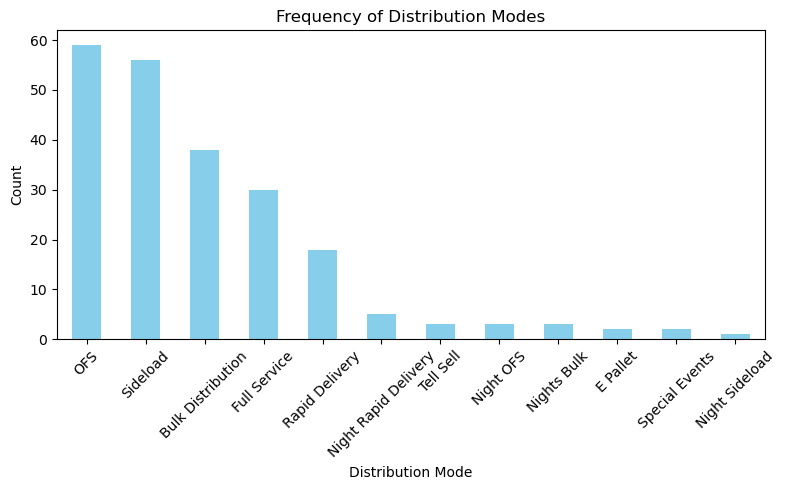

In [11]:
# Distribution mode chart
counts = cutoff['DISTRIBUTION_MODE'].value_counts()

# Plot
counts.plot(kind='bar', figsize=(8,5), color='skyblue')
plt.title("Frequency of Distribution Modes")
plt.ylabel("Count")
plt.xlabel("Distribution Mode")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Time of day customers must have their orders in by, by sales office
#     SALES_OFFICE - which sales office the customer orders from
#     PLANT_ID - which bottling plant the customer receives their order from
#     CUTOFFTIME_C - time the customer must have their order in. If NA then time is 5pm
#     SHIPPING_CONDITION_TIME - general shipping strategy for delivery of goods
#     DISTRIBUTION_MODE - mode of distrobution for a customer.


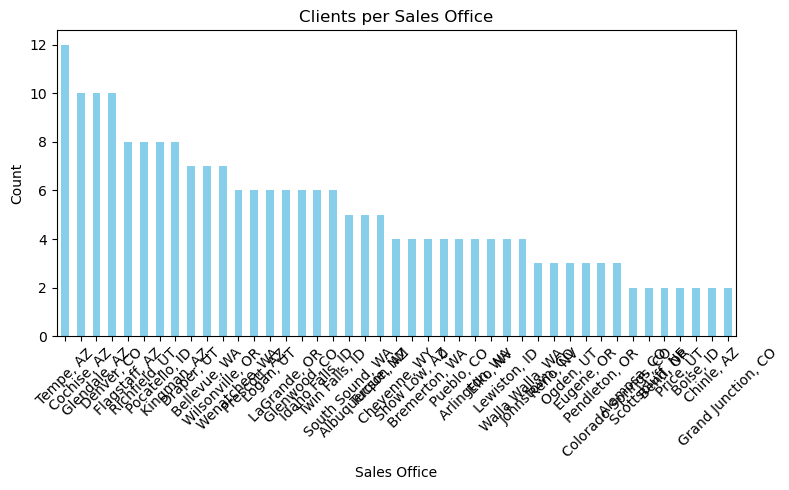

In [12]:
# Distribution mode chart
counts = cutoff['SALES_OFFICE'].value_counts()

# Plot
counts.plot(kind='bar', figsize=(8,5), color='skyblue')
plt.title("Clients per Sales Office")
plt.ylabel("Count")
plt.xlabel("Sales Office")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Customer

In [13]:
# Loading Customer Data

# customer info
#     SALES_OFFICE - sales office they order from
#     CUSTOMER_NUMBER - uniqe identifier for each customer
#     SALES_OFFICE_DESCRIPTION - location of sales office
#     SHIPPING_CONDITIONS_DESCRIPTION - general shipping strategy for the delivery of goods
#     COLD_DRINK_CHANNEL_DESCRIPTION - higher level grouping of customers such as retail, wholesale, eating/drinking
#     CUSTOMER_SUB_TRADE_CHANNEL_DESCRIPTION - lowest level grouping of customers with similar business product offerings and methods of selling within a trade channel
#     DISTROBUTION_MODE_DSCRIPTION - mode of distribution

customer = pd.read_csv("customer.csv")

# Should have 6334 rows and 7 cols

print(customer.shape)

(6334, 7)


In [14]:
# customer head
print(customer.head())

  SALES_OFFICE  CUSTOMER_NUMBER SALES_OFFICE_DESCRIPTION  \
0         G111        500964906               Draper, UT   
1         G111        501543906               Draper, UT   
2         G293        501394111               Tacoma, WA   
3         G238        501528559     Colorado Springs, CO   
4         G132        500504789              Alamosa, CO   

  DISTRIBUTION_MODE_DESCRIPTION SHIPPING_CONDITIONS_DESCRIPTION  \
0                      Sideload                        48 Hours   
1                      Sideload                        48 Hours   
2                           OFS                        24 Hours   
3                           OFS                        48 Hours   
4                           OFS                        48 Hours   

  COLD_DRINK_CHANNEL_DESCRIPTION CUSTOMER_SUB_TRADE_CHANNEL_DESCRIPTION  
0                     Restaurant                                 Dining  
1                     Restaurant                      Mexican Fast Food  
2             

In [15]:
# Customer Data Summary Stats
print(customer.info())
print(customer.describe(include="all"))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6334 entries, 0 to 6333
Data columns (total 7 columns):
 #   Column                                  Non-Null Count  Dtype 
---  ------                                  --------------  ----- 
 0   SALES_OFFICE                            6334 non-null   object
 1   CUSTOMER_NUMBER                         6334 non-null   int64 
 2   SALES_OFFICE_DESCRIPTION                6334 non-null   object
 3   DISTRIBUTION_MODE_DESCRIPTION           6330 non-null   object
 4   SHIPPING_CONDITIONS_DESCRIPTION         6334 non-null   object
 5   COLD_DRINK_CHANNEL_DESCRIPTION          6334 non-null   object
 6   CUSTOMER_SUB_TRADE_CHANNEL_DESCRIPTION  6334 non-null   object
dtypes: int64(1), object(6)
memory usage: 346.5+ KB
None
       SALES_OFFICE  CUSTOMER_NUMBER SALES_OFFICE_DESCRIPTION  \
count          6334     6.334000e+03                     6334   
unique           44              NaN                       44   
top            G111           

In [16]:
# missing values
print(customer.isna().sum())

SALES_OFFICE                              0
CUSTOMER_NUMBER                           0
SALES_OFFICE_DESCRIPTION                  0
DISTRIBUTION_MODE_DESCRIPTION             4
SHIPPING_CONDITIONS_DESCRIPTION           0
COLD_DRINK_CHANNEL_DESCRIPTION            0
CUSTOMER_SUB_TRADE_CHANNEL_DESCRIPTION    0
dtype: int64


In [17]:
# look at the 4 rows with missing data. Random forest 
print(customer[customer['DISTRIBUTION_MODE_DESCRIPTION'].isna()])

     SALES_OFFICE  CUSTOMER_NUMBER SALES_OFFICE_DESCRIPTION  \
1315         G235        600068066            Johnstown, CO   
4643         G111        600058005               Draper, UT   
5181         G265        501600865               Tucson, AZ   
6018         G163        600078326              Kingman, AZ   

     DISTRIBUTION_MODE_DESCRIPTION SHIPPING_CONDITIONS_DESCRIPTION  \
1315                           NaN                        48 Hours   
4643                           NaN                        48 Hours   
5181                           NaN                        48 Hours   
6018                           NaN                        48 Hours   

     COLD_DRINK_CHANNEL_DESCRIPTION CUSTOMER_SUB_TRADE_CHANNEL_DESCRIPTION  
1315                          Hotel                                  Motel  
4643                          Hotel                                  Motel  
5181                     Restaurant                             Restaurant  
6018                     

In [18]:
# replace missing values in DISTRIBUTION_MODE_DESCRIPTION with mode.
customer['DISTRIBUTION_MODE_DESCRIPTION'] = customer['DISTRIBUTION_MODE_DESCRIPTION'].fillna("unspecified")
customer['DISTRIBUTION_MODE_DESCRIPTION'].isna().sum()

0

In [19]:
# sales office distribution
customer['SALES_OFFICE_DESCRIPTION'].value_counts()

SALES_OFFICE_DESCRIPTION
Draper, UT              974
Tempe, AZ               403
Wilsonville, OR         379
Denver, CO              352
Tacoma, WA              304
Bellevue, WA            285
Boise, ID               270
Reno, NV                240
Glendale, AZ            237
Albuquerque, NM         222
Johnstown, CO           194
Arlington, WA           184
Spokane, WA             174
Tucson, AZ              169
Bremerton, WA           157
Ogden, UT               156
Colorado Springs, CO    139
Wenatchee, WA           113
Idaho Falls, ID          99
Glenwood Springs, CO     92
Twin Falls, ID           90
Bend, OR                 79
Flagstaff, AZ            75
Pocatello, ID            75
Eugene, OR               72
Logan, UT                65
Grand Junction, CO       64
Lewiston, ID             64
Kingman, AZ              60
Pueblo, CO               58
Richfield, UT            55
Huachuca City, AZ        55
Price, UT                50
Prescott, AZ             48
Walla Walla, WA        

In [20]:
# Customer dummy variables:
customer_dummies = pd.get_dummies(customer, columns=['DISTRIBUTION_MODE_DESCRIPTION', 'SHIPPING_CONDITIONS_DESCRIPTION', 'COLD_DRINK_CHANNEL_DESCRIPTION'], drop_first=True)
customer_dummies.head()

,SALES_OFFICE,CUSTOMER_NUMBER,SALES_OFFICE_DESCRIPTION,CUSTOMER_SUB_TRADE_CHANNEL_DESCRIPTION,DISTRIBUTION_MODE_DESCRIPTION_EZ Pallet,DISTRIBUTION_MODE_DESCRIPTION_Full Service,DISTRIBUTION_MODE_DESCRIPTION_Night OFS,DISTRIBUTION_MODE_DESCRIPTION_Night Rapid Delivery,DISTRIBUTION_MODE_DESCRIPTION_Night Side Load,DISTRIBUTION_MODE_DESCRIPTION_OFS,...,SHIPPING_CONDITIONS_DESCRIPTION_Dropsite 24 Hours,SHIPPING_CONDITIONS_DESCRIPTION_Dropsite 48 Hours,COLD_DRINK_CHANNEL_DESCRIPTION_Clinic,COLD_DRINK_CHANNEL_DESCRIPTION_Distributor,COLD_DRINK_CHANNEL_DESCRIPTION_Hot Beverage,COLD_DRINK_CHANNEL_DESCRIPTION_Hotel,COLD_DRINK_CHANNEL_DESCRIPTION_Institution,COLD_DRINK_CHANNEL_DESCRIPTION_Restaurant,COLD_DRINK_CHANNEL_DESCRIPTION_Store,COLD_DRINK_CHANNEL_DESCRIPTION_Workplace
0,G111,500964906,"Draper, UT",Dining,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
1,G111,501543906,"Draper, UT",Mexican Fast Food,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
2,G293,501394111,"Tacoma, WA",Recreation Center,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
3,G238,501528559,"Colorado Springs, CO",Recreation Center,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
4,G132,500504789,"Alamosa, CO",Fast Food,False,False,False,False,False,True,...,False,False,False,False,False,False,False,True,False,False


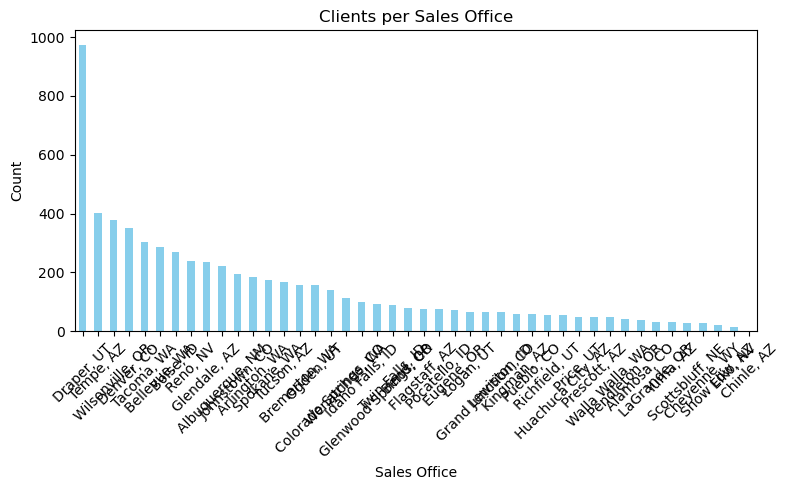

In [21]:
# Sales Office distribution
counts1 = customer['SALES_OFFICE_DESCRIPTION'].value_counts()

# Plot
counts1.plot(kind='bar', figsize=(8,5), color='skyblue')
plt.title("Clients per Sales Office")
plt.ylabel("Count")
plt.xlabel("Sales Office")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

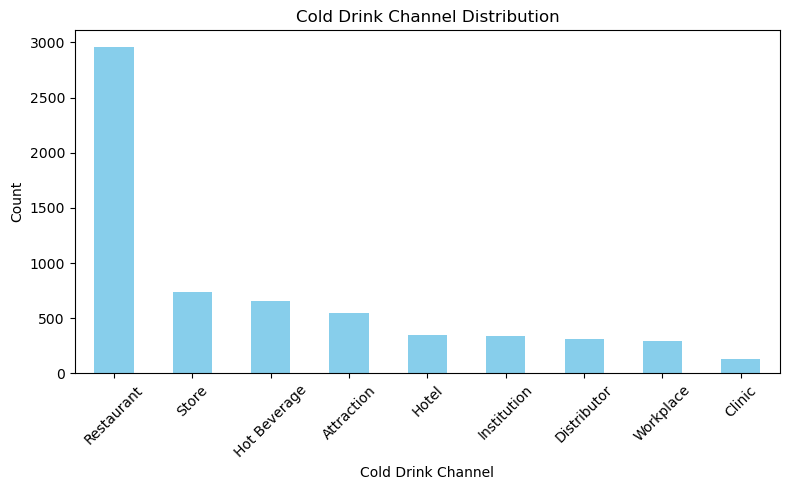

In [22]:
# Cold Drink Channel Distribution
counts1 = customer['COLD_DRINK_CHANNEL_DESCRIPTION'].value_counts()

# Plot
counts1.plot(kind='bar', figsize=(8,5), color='skyblue')
plt.title("Cold Drink Channel Distribution")
plt.ylabel("Count")
plt.xlabel("Cold Drink Channel")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

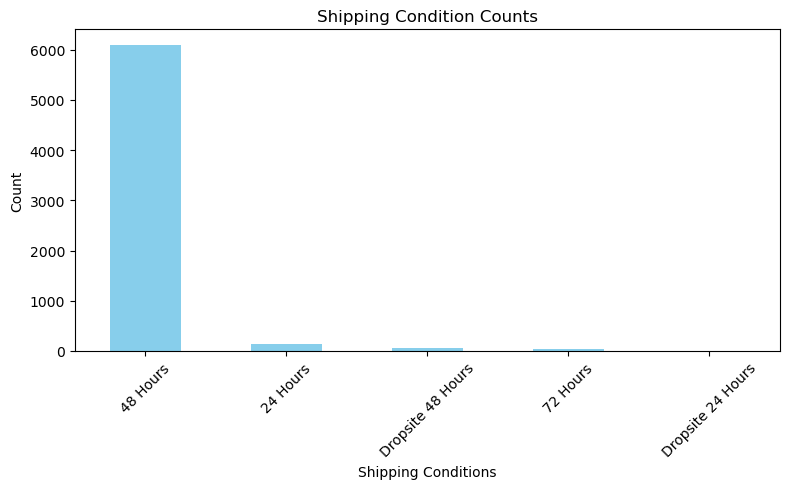

In [23]:
# Shipping Conditions Distribution
counts1 = customer['SHIPPING_CONDITIONS_DESCRIPTION'].value_counts()

# Plot
counts1.plot(kind='bar', figsize=(8,5), color='skyblue')
plt.title("Shipping Condition Counts")
plt.ylabel("Count")
plt.xlabel("Shipping Conditions")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Material

In [24]:
# Loading Material Data

# Specific product info
#     MATERIAL_ID - unique identifier for the product
#     BEV_CAT_DESC - category of drink(juice, energy drink, soda)
#     PACK_TYPE_DESC - package type
#     TRADE_MARK_DESC - brank of product
#     FLAVOUR_DESC - flavor of product
#     PACK_SIZE_DESC - size of product

material = pd.read_csv("material.csv")

# Should have 1252 rows and 6 cols

print(material.shape)

(1252, 6)


In [25]:
# head
print(material.head())

   MATERIAL_ID          PACK_TYPE_DESC   TRADE_MARK_DESC    FLAVOUR_DESC  \
0       125522  Plastic Bottle - Other  Oliver Originals  Salted Caramel   
1       116974           Styrofoam Lid         Sunny Sip    Passionfruit   
2       113144              Bag-In-Box             Sam's       Bubblegum   
3       410256            Aluminum Can     Jack's Juices      Cappuccino   
4       146980            Aluminum Can  Oliver Originals   Vanilla Latte   

  PACK_SIZE_DESC    BEV_CAT_DESC  
0          20 OZ  CORE SPARKLING  
1          24 OZ             NaN  
2     2.5 GALLON  JUICES/NECTARS  
3          12 OZ  CORE SPARKLING  
4          16 OZ  CORE SPARKLING  


In [26]:
# Missing values
print(material.isna().sum())

MATERIAL_ID          0
PACK_TYPE_DESC       0
TRADE_MARK_DESC      0
FLAVOUR_DESC         0
PACK_SIZE_DESC       0
BEV_CAT_DESC       134
dtype: int64


In [27]:
# Material Summary stats
print(material.info())
print(material.describe(include="all"))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1252 entries, 0 to 1251
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   MATERIAL_ID      1252 non-null   int64 
 1   PACK_TYPE_DESC   1252 non-null   object
 2   TRADE_MARK_DESC  1252 non-null   object
 3   FLAVOUR_DESC     1252 non-null   object
 4   PACK_SIZE_DESC   1252 non-null   object
 5   BEV_CAT_DESC     1118 non-null   object
dtypes: int64(1), object(5)
memory usage: 58.8+ KB
None
          MATERIAL_ID PACK_TYPE_DESC TRADE_MARK_DESC  FLAVOUR_DESC  \
count     1252.000000           1252            1252          1252   
unique            NaN             20              14           172   
top               NaN   Aluminum Can    Fizz Factory  Passionfruit   
freq              NaN            366             402           134   
mean    261796.908946            NaN             NaN           NaN   
std     180385.189072            NaN             NaN      

In [28]:
# Replace missing values in BEV_CAT_DESC:
empty = material[material['BEV_CAT_DESC'].isna()]
print(empty["TRADE_MARK_DESC"].value_counts())

TRADE_MARK_DESC
Sunny Sip    134
Name: count, dtype: int64


In [29]:
material['BEV_CAT_DESC'] = material['BEV_CAT_DESC'].fillna('SUNNY_SIP')
material['BEV_CAT_DESC'].isna().sum()

0

In [30]:
# Material dummy variables:
material_dummies = pd.get_dummies(material, columns=['BEV_CAT_DESC', 'TRADE_MARK_DESC', 'PACK_TYPE_DESC', 'PACK_SIZE_DESC'], drop_first=True)
material_dummies.head()

,MATERIAL_ID,FLAVOUR_DESC,BEV_CAT_DESC_CORE SPARKLING,BEV_CAT_DESC_DAIRY/SOY BEVERAGES,BEV_CAT_DESC_ENERGY DRINKS,BEV_CAT_DESC_ENHANCED WATER BEVERAGES,BEV_CAT_DESC_FRUIT/VEGETABLE STILL DRINKS,BEV_CAT_DESC_JUICES/NECTARS,BEV_CAT_DESC_OTHER NONALCOHOLIC BEVERAGES,BEV_CAT_DESC_PACKAGED WATER (PLAIN & ENRICHED),...,PACK_SIZE_DESC_52 OUNCE,PACK_SIZE_DESC_59 OZ,PACK_SIZE_DESC_620 ML,PACK_SIZE_DESC_64 OZ,PACK_SIZE_DESC_7.1 OZ,PACK_SIZE_DESC_7.5 OZ,PACK_SIZE_DESC_7.7 DRY OZ,PACK_SIZE_DESC_8 OZ,PACK_SIZE_DESC_9 OZ,PACK_SIZE_DESC_Not Applicable
0,125522,Salted Caramel,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,116974,Passionfruit,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,113144,Bubblegum,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
3,410256,Cappuccino,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,146980,Vanilla Latte,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


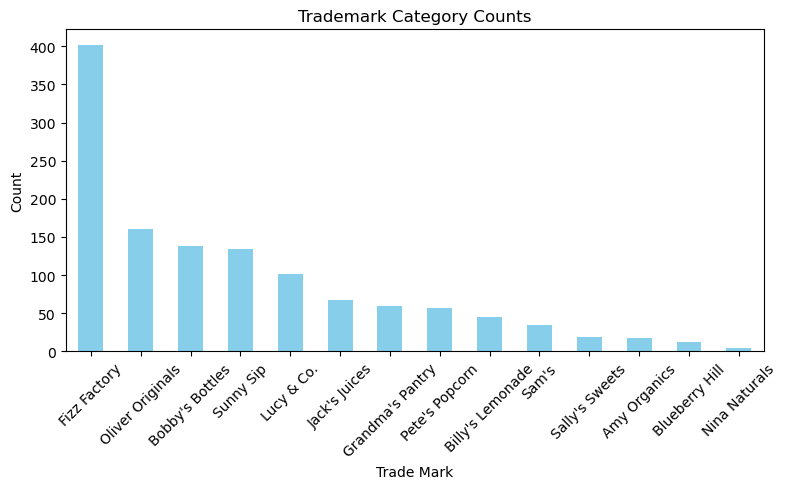

In [31]:
# Trade Mark Distribution
counts1 = material['TRADE_MARK_DESC'].value_counts()

# Plot
counts1.plot(kind='bar', figsize=(8,5), color='skyblue')
plt.title("Trademark Category Counts")
plt.ylabel("Count")
plt.xlabel("Trade Mark")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

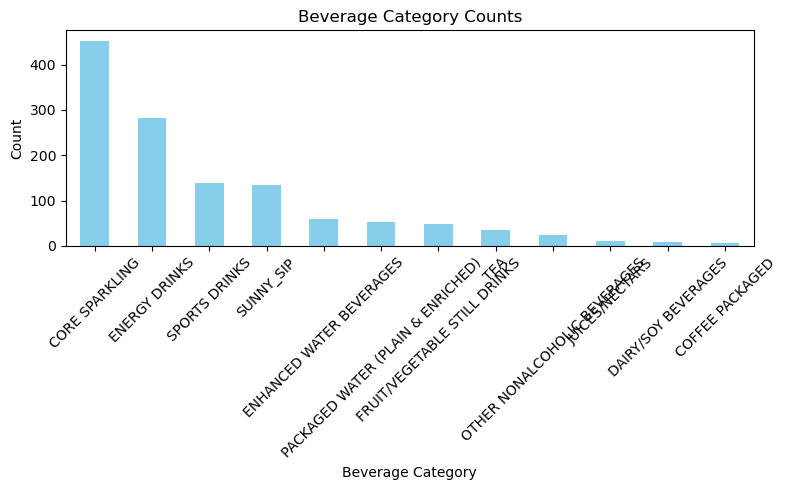

In [32]:
# Beverage Category Distribution
counts1 = material['BEV_CAT_DESC'].value_counts()

# Plot
counts1.plot(kind='bar', figsize=(8,5), color='skyblue')
plt.title("Beverage Category Counts")
plt.ylabel("Count")
plt.xlabel("Beverage Category")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Operating Hours

In [33]:
# Loading Operating Hours Data

# Day of the week and how often a customer is scheduled to place an order
#     CUSTOMER_NUMBER - unique identifier for each customer
#     FREQUENCY - how often a customer will receive deliveries
#     DELIVERY_ANCHOR_dAY - day of the week customer receives their order
#     CALLING_ANCHOR_DATE - the day the delivery policy starts

op_hours = pd.read_csv("operating_hours.csv")

# Should have 6202 rows and 4 cols

print(op_hours.shape)

(6202, 4)


In [34]:
print(op_hours.head())

   CUSTOMER_NUMBER      FREQUENCY DELIVERY_ANCHOR_DAY CALLING_ANCHOR_DATE
0        600069597  Every 4 Weeks              Friday            2/5/2025
1        501562126  Every 4 Weeks             Tuesday           1/26/2025
2        500324496  Every 4 Weeks             Tuesday            2/2/2025
3        600259095     Every Week           Wednesday            2/4/2025
4        501072497     Every Week             Tuesday          11/17/2024


In [35]:
# Missing values
print(op_hours.isna().sum())

CUSTOMER_NUMBER        0
FREQUENCY              0
DELIVERY_ANCHOR_DAY    0
CALLING_ANCHOR_DATE    0
dtype: int64


In [36]:
# Operating Hours Summary stats
print(op_hours.info())
print(op_hours.describe(include="all"))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6202 entries, 0 to 6201
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   CUSTOMER_NUMBER      6202 non-null   int64 
 1   FREQUENCY            6202 non-null   object
 2   DELIVERY_ANCHOR_DAY  6202 non-null   object
 3   CALLING_ANCHOR_DATE  6202 non-null   object
dtypes: int64(1), object(3)
memory usage: 193.9+ KB
None
        CUSTOMER_NUMBER      FREQUENCY DELIVERY_ANCHOR_DAY CALLING_ANCHOR_DATE
count      6.202000e+03           6202                6202                6202
unique              NaN              4                   7                 322
top                 NaN  Every 4 Weeks           Wednesday            2/2/2025
freq                NaN           2562                1343                 177
mean       5.240876e+08            NaN                 NaN                 NaN
std        4.160806e+07            NaN                 NaN           

In [37]:
# Convert CALLING_ANCHOR_DATE to datetime
op_hours['CALLING_ANCHOR_DATE'] = pd.to_datetime(op_hours['CALLING_ANCHOR_DATE'], format='%m/%d/%Y')
op_hours['CALLING_ANCHOR_DATE'].dtype

dtype('<M8[ns]')

In [38]:
# Operating Hours dummy variables:
ophrs_dummies = pd.get_dummies(op_hours, columns=['FREQUENCY', 'DELIVERY_ANCHOR_DAY'], drop_first=True)
ophrs_dummies.head()

,CUSTOMER_NUMBER,CALLING_ANCHOR_DATE,FREQUENCY_Every 3 Weeks,FREQUENCY_Every 4 Weeks,FREQUENCY_Every Week,DELIVERY_ANCHOR_DAY_Friday,DELIVERY_ANCHOR_DAY_Monday,DELIVERY_ANCHOR_DAY_Sunday,DELIVERY_ANCHOR_DAY_Thursday,DELIVERY_ANCHOR_DAY_Tuesday,DELIVERY_ANCHOR_DAY_Wednesday
0,600069597,2025-02-05,False,True,False,True,False,False,False,False,False
1,501562126,2025-01-26,False,True,False,False,False,False,False,True,False
2,500324496,2025-02-02,False,True,False,False,False,False,False,True,False
3,600259095,2025-02-04,False,False,True,False,False,False,False,False,True
4,501072497,2024-11-17,False,False,True,False,False,False,False,True,False


In [39]:
op_hours['DELIVERY_ANCHOR_DAY'] = op_hours['DELIVERY_ANCHOR_DAY'].replace('Error', 'Saturday')

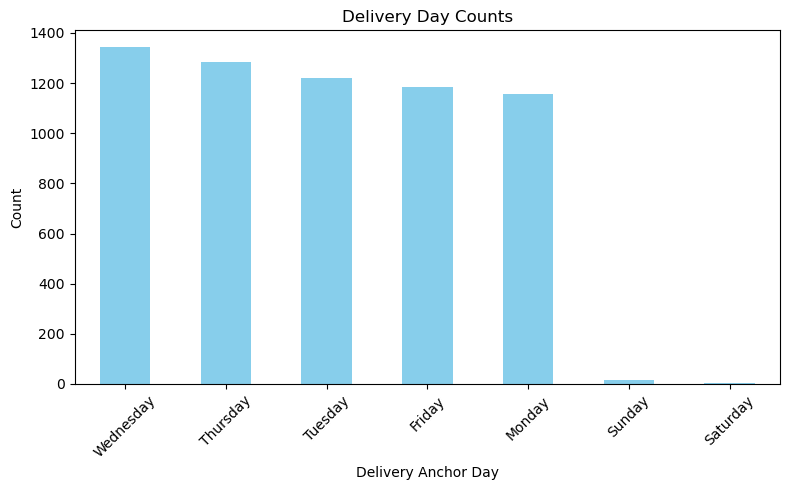

In [40]:
# Delivery Anchor Day Distribution
counts1 = op_hours['DELIVERY_ANCHOR_DAY'].value_counts()

# Plot
counts1.plot(kind='bar', figsize=(8,5), color='skyblue')
plt.title("Delivery Day Counts")
plt.ylabel("Count")
plt.xlabel("Delivery Anchor Day")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Sales

In [41]:
# Loading Sales Data

# Which items were sold
#     CUSTOMER_ID - unique customer identifier
#     POSTING_DATE - date financial transaction if recorded
#     MATERIAL_ID - unique identifier for the product
#     GROSS_PROFIT_DEAD_NET - bottler gross profit after invoice allowance with customer marketing expenses and rebates subtracted
#     NSI_DEAD_NET - bottler sales revnue
#     PHYSICAL_VOLUME - case volume of product in that order

sales = pd.read_csv("sales.csv")

# Should have 499,787 rows and 8 cols

print(sales.shape)

(499787, 8)


In [42]:
# sales head
print(sales.head())

   CUSTOMER_ID POSTING_DATE  MATERIAL_ID  GROSS_PROFIT_DEAD_NET  \
0    501473438   2024-06-10       123159                  53.60   
1    501473438   2024-06-10       115584                  21.76   
2    501502460   2024-06-10       103996                  -0.89   
3    501168843   2024-06-10       156091                  10.20   
4    501583464   2024-06-10       119827                  42.15   

   PHYSICAL_VOLUME     NSI  NSI_DEAD_NET  GROSS_PROFIT  
0              8.0  111.04        111.04         53.60  
1              4.0   51.12         51.12         21.76  
2              2.0  210.80        210.80         -0.89  
3              2.0   30.50         30.50         10.20  
4              4.0   98.40         88.40         52.15  


In [43]:
# sales missing values
print(sales.isna().sum())

CUSTOMER_ID              0
POSTING_DATE             0
MATERIAL_ID              0
GROSS_PROFIT_DEAD_NET    0
PHYSICAL_VOLUME          0
NSI                      0
NSI_DEAD_NET             0
GROSS_PROFIT             0
dtype: int64


In [44]:
# Sales Summary stats
print(sales.info())
print(sales.describe(include="all"))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499787 entries, 0 to 499786
Data columns (total 8 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   CUSTOMER_ID            499787 non-null  int64  
 1   POSTING_DATE           499787 non-null  object 
 2   MATERIAL_ID            499787 non-null  int64  
 3   GROSS_PROFIT_DEAD_NET  499787 non-null  float64
 4   PHYSICAL_VOLUME        499787 non-null  float64
 5   NSI                    499787 non-null  float64
 6   NSI_DEAD_NET           499787 non-null  float64
 7   GROSS_PROFIT           499787 non-null  float64
dtypes: float64(5), int64(2), object(1)
memory usage: 30.5+ MB
None
         CUSTOMER_ID POSTING_DATE    MATERIAL_ID  GROSS_PROFIT_DEAD_NET  \
count   4.997870e+05       499787  499787.000000          499787.000000   
unique           NaN          313            NaN                    NaN   
top              NaN   2024-07-03            NaN                   

In [45]:
# Sales Correlations:
sales.corr(numeric_only=True)
# remove customer_id, nsi, and gross_profit

,CUSTOMER_ID,MATERIAL_ID,GROSS_PROFIT_DEAD_NET,PHYSICAL_VOLUME,NSI,NSI_DEAD_NET,GROSS_PROFIT
CUSTOMER_ID,1.000000,0.030802,0.068998,0.092913,0.078671,0.078885,0.073609
MATERIAL_ID,0.030802,1.000000,-0.045260,-0.022638,-0.017341,-0.015670,-0.037265
GROSS_PROFIT_DEAD_NET,0.068998,-0.045260,1.000000,0.819643,0.832451,0.841053,0.933765
PHYSICAL_VOLUME,0.092913,-0.022638,0.819643,1.000000,0.883800,0.883551,0.805916
NSI,0.078671,-0.017341,0.832451,0.883800,1.000000,0.991186,0.821789
NSI_DEAD_NET,0.078885,-0.015670,0.841053,0.883551,0.991186,1.000000,0.787638
GROSS_PROFIT,0.073609,-0.037265,0.933765,0.805916,0.821789,0.787638,1.000000


In [46]:
# Convert POSTING_DATE to datetime
sales['POSTING_DATE'] = pd.to_datetime(sales['POSTING_DATE'], format='%Y-%m-%d')
sales['POSTING_DATE'].dtypes

dtype('<M8[ns]')

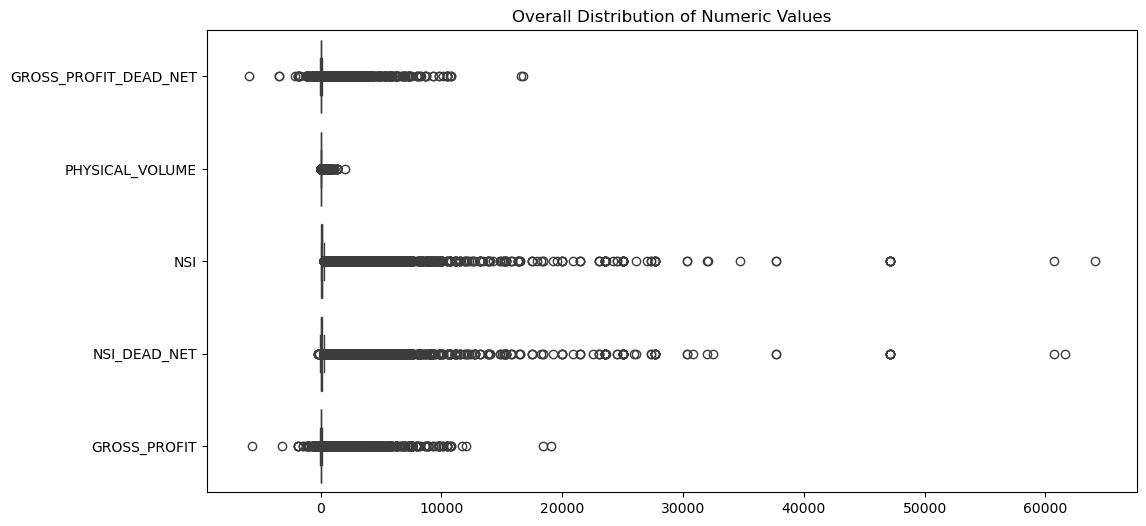

In [47]:
import seaborn as sns
# Select numeric columns (excluding ID-like fields)
numeric_cols = ['GROSS_PROFIT_DEAD_NET', 'PHYSICAL_VOLUME', 'NSI', 'NSI_DEAD_NET', 'GROSS_PROFIT']

# Create boxplots
plt.figure(figsize=(12, 6))
sns.boxplot(data=sales[numeric_cols], orient="h")
plt.title("Overall Distribution of Numeric Values")
plt.show()
# this plot with grubs test to remove proportional outliers

### Orders

In [48]:
# Loading Orders Data

# Items ordered
#     CUSTOMER_ID - unique customer identifier
#     CREATED_DATE_EST - date the order was created
#     CREATED_DATE_UTC - timestamp for order
#     MATERIAL_ID - unique identifier for the product
#     ORDER_QUANTITY - quantity of items
#     ORDER_TYPE - method used by customer to place order
#     PLANT_ID - bottling plant customer receives order from

orders = pd.read_csv("orders.csv")

# Should have 1,662,157 rows and 7 cols

print(orders.shape)

(1662157, 7)


In [49]:
# orders head
print(orders.head())

   CUSTOMER_ID CREATED_DATE_EST          CREATED_DATE_UTC  MATERIAL_ID  \
0    600265510       2025-01-10  2025-01-10T22:40:25.000Z     152965.0   
1    600584506       2024-11-22  2024-11-22T17:34:30.000Z     156127.0   
2    600686120       2024-06-04  2024-06-05T00:29:33.000Z     103886.0   
3    501087671       2024-12-03  2024-12-03T18:14:23.000Z     134926.0   
4    501680332       2025-03-31  2025-03-31T22:33:07.000Z     152196.0   

   ORDER_QUANTITY   ORDER_TYPE PLANT_ID  
0             1.0  CALL CENTER     G267  
1             1.0    SALES REP     G221  
2             1.0    SALES REP     G291  
3             2.0    SALES REP     G163  
4             1.0    SALES REP     G221  


In [50]:
# orders missing values
print(orders.isna().sum())

CUSTOMER_ID           0
CREATED_DATE_EST      0
CREATED_DATE_UTC      0
MATERIAL_ID         195
ORDER_QUANTITY        0
ORDER_TYPE            0
PLANT_ID             11
dtype: int64


In [82]:
orders = orders.dropna()
orders.shape

(1661962, 7)

In [51]:
# Orders Summary stats
print(orders.info())
print(orders.describe(include="all"))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1662157 entries, 0 to 1662156
Data columns (total 7 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   CUSTOMER_ID       1662157 non-null  int64  
 1   CREATED_DATE_EST  1662157 non-null  object 
 2   CREATED_DATE_UTC  1662157 non-null  object 
 3   MATERIAL_ID       1661962 non-null  float64
 4   ORDER_QUANTITY    1662157 non-null  float64
 5   ORDER_TYPE        1662157 non-null  object 
 6   PLANT_ID          1662146 non-null  object 
dtypes: float64(2), int64(1), object(4)
memory usage: 88.8+ MB
None
         CUSTOMER_ID CREATED_DATE_EST          CREATED_DATE_UTC   MATERIAL_ID  \
count   1.662157e+06          1662157                   1662157  1.661962e+06   
unique           NaN              359                    112390           NaN   
top              NaN       2025-05-15  2024-08-05T19:28:03.000Z           NaN   
freq             NaN            17185                  

In [52]:
# Convert CREATED_DATE_EST and CREATED_DATE_UTC to datetime
orders['CREATED_DATE_EST'] = pd.to_datetime(orders['CREATED_DATE_EST'], format='%Y-%m-%d')
orders['CREATED_DATE_UTC'] = pd.to_datetime(orders['CREATED_DATE_UTC'])
orders[['CREATED_DATE_UTC', 'CREATED_DATE_EST']].dtypes

CREATED_DATE_UTC    datetime64[ns, UTC]
CREATED_DATE_EST         datetime64[ns]
dtype: object

In [53]:
# Dropping rows with missing material_id:
orders = orders.dropna(subset=['MATERIAL_ID'])
orders.shape

(1661962, 7)

In [54]:
# convert material id to int:
orders['MATERIAL_ID'] = orders['MATERIAL_ID'].astype('Int64')
orders['MATERIAL_ID'].head()

0    152965
1    156127
2    103886
3    134926
4    152196
Name: MATERIAL_ID, dtype: Int64

In [55]:
orders_dummies = pd.get_dummies(orders, columns=['ORDER_TYPE', 'PLANT_ID'], drop_first=True)

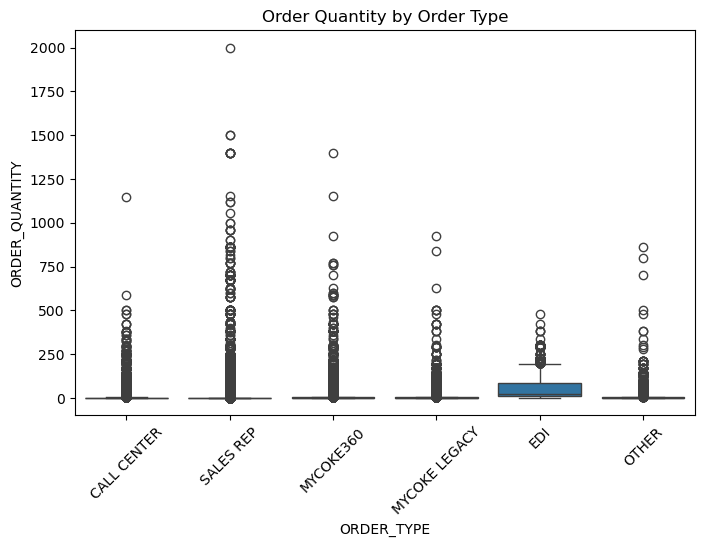

In [56]:
#distribution by order type
plt.figure(figsize=(8, 5))
sns.boxplot(x='ORDER_TYPE', y='ORDER_QUANTITY', data=orders)
plt.title('Order Quantity by Order Type')
plt.xticks(rotation=45)
plt.show()

### Visit Plan

In [57]:
# Loading Visit Plan Data

# Day of the week and how often a customer is scheduled to place an order
#     CUSTOMER_ID - unique customer identifier
#     FREQUENCY - how often a customer will receive a delivery
#     ELT_TS - timestamp of when the policy was logged
#     SNAPSHOT_DATE - date of when the policy was logged
#     ANCHOR_DATE - day of the week that customer receives their order
#     SALES_OFFICE - id of sales office the customer orders from
#     SALES_OFFICE_DESC - city of which sales office the customer orders from
#     DISTROBUTION_MODE - mode of distrobution for a customer
#     SHIPPING_CONDITIONS_DESC - general shipping strategy for the delivery of goods from vendor to customer. 

visit_plan = pd.read_csv("visit_plan.csv", low_memory = False)

# Should have 14,796,017 rows and 9 cols

print(visit_plan.shape)

(13638683, 9)


In [58]:
# visit plan head
print(visit_plan.head())

   CUSTOMER_ID FREQUENCY                    ELT_TS SNAPSHOT_DATE ANCHOR_DATE  \
0    500405850        02  2021-12-14T05:49:54.551Z    2021-12-13  2020-07-20   
1    500286563        01  2021-12-14T05:49:54.551Z    2021-12-13  2019-11-04   
2    600057832        01  2021-12-14T05:49:54.551Z    2021-12-13  2021-08-02   
3    500431853        01  2021-12-14T05:49:54.551Z    2021-12-13  2020-04-06   
4    600076074        01  2021-12-14T05:49:54.551Z    2021-12-13  2019-06-07   

  SALES_OFFICE     SALES_OFFICE_DESC DISTRIBUTION_MODE  \
0         G133  Glenwood Springs, CO                SL   
1         G236            Denver, CO                OF   
2         G111            Draper, UT                SL   
3         G111            Draper, UT                SL   
4         G142         Pocatello, ID                EZ   

  SHIPPING_CONDITIONS_DESC  
0                 48 Hours  
1                 48 Hours  
2                 48 Hours  
3                 48 Hours  
4                 24 Hour

In [59]:
# visit plan missing values
print(visit_plan.isna().sum())

CUSTOMER_ID                     0
FREQUENCY                   13961
ELT_TS                          0
SNAPSHOT_DATE                   0
ANCHOR_DATE                 13962
SALES_OFFICE                   74
SALES_OFFICE_DESC              74
DISTRIBUTION_MODE           15296
SHIPPING_CONDITIONS_DESC       74
dtype: int64


In [80]:
# Dropping rows with empty.
visit_plan = visit_plan.dropna()
visit_plan.shape

(13609319, 9)

In [60]:
# Visit Plan Summary stats
print(visit_plan.info())
print(visit_plan.describe(include="all"))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13638683 entries, 0 to 13638682
Data columns (total 9 columns):
 #   Column                    Dtype 
---  ------                    ----- 
 0   CUSTOMER_ID               int64 
 1   FREQUENCY                 object
 2   ELT_TS                    object
 3   SNAPSHOT_DATE             object
 4   ANCHOR_DATE               object
 5   SALES_OFFICE              object
 6   SALES_OFFICE_DESC         object
 7   DISTRIBUTION_MODE         object
 8   SHIPPING_CONDITIONS_DESC  object
dtypes: int64(1), object(8)
memory usage: 936.5+ MB
None
         CUSTOMER_ID FREQUENCY                    ELT_TS SNAPSHOT_DATE  \
count   1.363868e+07  13624722                  13638683      13638683   
unique           NaN        24                      9467          1378   
top              NaN        01  2025-07-20T01:32:43.859Z    2025-03-10   
freq             NaN   8174918                     13827         16034   
mean    5.374353e+08       NaN           

In [61]:
#converting ELT_TS, ANCHOR_DATE, and SNAPSHOT_DATE to datetime
visit_plan['ELT_TS'] = pd.to_datetime(visit_plan['ELT_TS'])
visit_plan['ANCHOR_DATE'] = pd.to_datetime(visit_plan['ANCHOR_DATE'], format='%Y-%m-%d', errors='coerce')
visit_plan['SNAPSHOT_DATE'] = pd.to_datetime(visit_plan['SNAPSHOT_DATE'], format='%Y-%m-%d', errors='coerce')
visit_plan[['ELT_TS', 'SNAPSHOT_DATE', 'ANCHOR_DATE']].dtypes

ELT_TS           datetime64[ns, UTC]
SNAPSHOT_DATE         datetime64[ns]
ANCHOR_DATE           datetime64[ns]
dtype: object

In [62]:
# converting frequency to int:
# finding unique sales offices
unique_freq = visit_plan["FREQUENCY"].unique()
print(unique_freq)

# no idea what any of this means

['02' '01' '04' 'Every Second Week On' 'Every Week On'
 'Every Fourth Week On' 'Every Third Week On' 'Every Tenth Week On' '03'
 'Every Fifth Week On' 'Every Eighth Week On' nan 'Not Applicable'
 'Every Sixth Week On' '1 ' '2 ' '4 ' '3 ' '10' '05' ' 1' '5 ' '8 ' '08'
 '06']


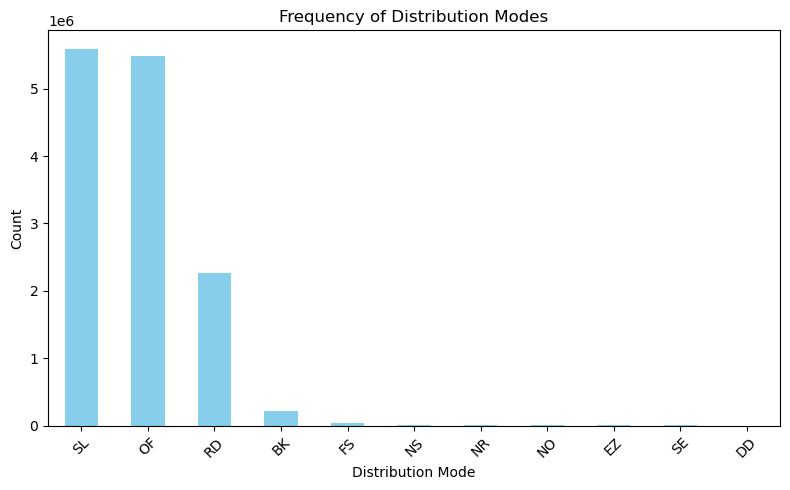

In [63]:
# Distribution mode chart
counts = visit_plan['DISTRIBUTION_MODE'].value_counts()

# Plot
counts.plot(kind='bar', figsize=(8,5), color='skyblue')
plt.title("Frequency of Distribution Modes")
plt.ylabel("Count")
plt.xlabel("Distribution Mode")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

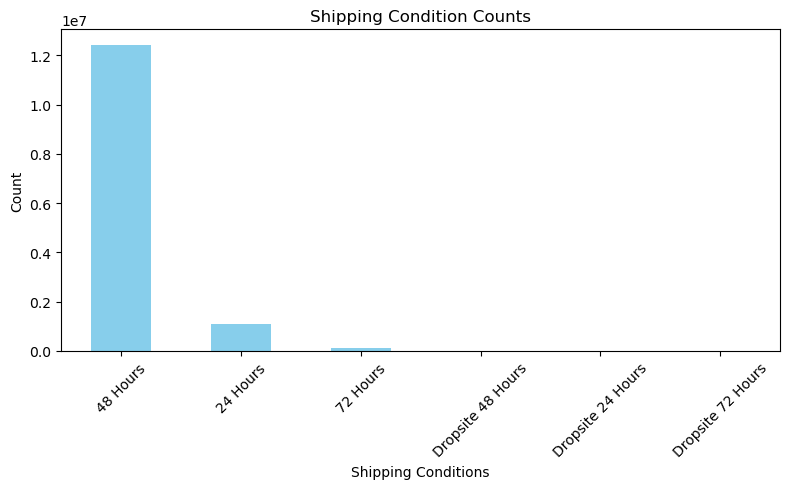

In [64]:
# Shipping Conditions chart
counts = visit_plan['SHIPPING_CONDITIONS_DESC'].value_counts()

# Plot
counts.plot(kind='bar', figsize=(8,5), color='skyblue')
plt.title("Shipping Condition Counts")
plt.ylabel("Count")
plt.xlabel("Shipping Conditions")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [65]:
# creating dummies for visit plan
visit_plan_dummies = pd.get_dummies(visit_plan, columns=['SHIPPING_CONDITIONS_DESC', 'DISTRIBUTION_MODE', 'SALES_OFFICE_DESC', 'SALES_OFFICE', 'FREQUENCY'], drop_first=True)

In [66]:
# sample anchor dates for random customers
visit_plan.loc[visit_plan["CUSTOMER_ID"] == 500431853].groupby("ANCHOR_DATE").count()

,CUSTOMER_ID,FREQUENCY,ELT_TS,SNAPSHOT_DATE,SALES_OFFICE,SALES_OFFICE_DESC,DISTRIBUTION_MODE,SHIPPING_CONDITIONS_DESC
ANCHOR_DATE,,,,,,,,
2020-04-06,220,220,220,220,220,220,220,220
2020-04-10,1427,1427,1427,1427,1427,1427,1427,1427
2022-06-16,4,4,4,4,4,4,4,4
2022-06-21,3,3,3,3,3,3,3,3
2022-06-23,1066,1066,1066,1066,1066,1066,1066,1066
2023-04-24,563,563,563,563,563,563,563,563
2024-11-20,219,219,219,219,219,219,219,219


In [67]:
visit_plan.loc[visit_plan["CUSTOMER_ID"] == 600076074].groupby("ANCHOR_DATE").count()

,CUSTOMER_ID,FREQUENCY,ELT_TS,SNAPSHOT_DATE,SALES_OFFICE,SALES_OFFICE_DESC,DISTRIBUTION_MODE,SHIPPING_CONDITIONS_DESC
ANCHOR_DATE,,,,,,,,
2019-06-06,463,463,463,463,463,463,463,463
2019-06-07,1187,1187,1187,1187,1187,1187,1187,1187
2023-03-13,25,25,25,25,25,25,25,25
2023-03-29,806,806,806,806,806,806,806,806
2023-03-31,267,267,267,267,267,267,267,267
2023-12-18,203,203,203,203,203,203,203,203
2024-02-28,376,376,376,376,376,376,376,376
2024-03-01,377,377,377,377,377,377,377,377
2025-03-31,106,106,106,106,106,106,106,106


### Google Analytics

In [68]:
# Loading Google Analytics Data

# Website events
#     CUSTOMER_ID - unique identifier for each customer
#     EVENT_DATE - date of event on myCoke360
#     EVENT_TIMESTAMP - timestamp of event
#     EVENT_NAME - action the customer took
#     DEVICE_CATEGORY - type of device
#     DEVICE_MOBILE_BRAND_NAME - brand of device
#     DEVICE_OPERATING_SYSTEM - OS of device used
#     EVENT_PAGE_NAME - name of page viewed
#     EVENT_PAGE_TITLE - title of page viewed
#     ITEMS - list of material ids and quantities

google_a = pd.read_csv("google_analytics.csv")

# should have 3,704,088 rows and 10 cols

print(google_a.shape)

(3704088, 10)


In [69]:
# google head
print(google_a.head())

   CUSTOMER_ID  EVENT_DATE           EVENT_TIMESTAMP           EVENT_NAME  \
0    501508595  2025-04-07  2025-04-07T14:57:40.713Z  view_search_results   
1    501730915  2025-04-07  2025-04-07T19:28:54.546Z       view_item_list   
2    501567329  2025-04-07  2025-04-07T21:40:56.281Z             purchase   
3    501765083  2025-04-08  2025-04-08T06:06:36.717Z      user_engagement   
4    501707837  2025-04-08  2025-04-08T18:12:10.511Z       view_item_list   

  DEVICE_CATEGORY DEVICE_MOBILE_BRAND_NAME DEVICE_OPERATING_SYSTEM  \
0          mobile                  Samsung                 Android   
1         desktop                   Google                 Windows   
2         desktop                   Google                 Windows   
3          mobile                    Apple                     iOS   
4         desktop                   Google                 Windows   

                    EVENT_PAGE_NAME        EVENT_PAGE_TITLE  \
0                      Product List                  

In [70]:
# google missing values
print(google_a.isna().sum())

CUSTOMER_ID                       0
EVENT_DATE                        0
EVENT_TIMESTAMP                   0
EVENT_NAME                        0
DEVICE_CATEGORY                   0
DEVICE_MOBILE_BRAND_NAME      39468
DEVICE_OPERATING_SYSTEM           0
EVENT_PAGE_NAME             1002510
EVENT_PAGE_TITLE             318091
ITEMS                             0
dtype: int64


In [71]:
# Google Analytics Summary stats
print(google_a.info())
print(google_a.describe(include="all"))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3704088 entries, 0 to 3704087
Data columns (total 10 columns):
 #   Column                    Dtype 
---  ------                    ----- 
 0   CUSTOMER_ID               int64 
 1   EVENT_DATE                object
 2   EVENT_TIMESTAMP           object
 3   EVENT_NAME                object
 4   DEVICE_CATEGORY           object
 5   DEVICE_MOBILE_BRAND_NAME  object
 6   DEVICE_OPERATING_SYSTEM   object
 7   EVENT_PAGE_NAME           object
 8   EVENT_PAGE_TITLE          object
 9   ITEMS                     object
dtypes: int64(1), object(9)
memory usage: 282.6+ MB
None
         CUSTOMER_ID  EVENT_DATE           EVENT_TIMESTAMP EVENT_NAME  \
count   3.704088e+06     3704088                   3704088    3704088   
unique           NaN         360                   1953644        151   
top              NaN  2025-05-19  2025-01-15T15:24:02.206Z  page_view   
freq             NaN       31685                        20    1198482   
mean    5

In [72]:
# replacing missing values
google_a['DEVICE_MOBILE_BRAND_NAME'] = google_a['DEVICE_MOBILE_BRAND_NAME'].fillna('OTHER')
google_a['EVENT_PAGE_NAME'] = google_a['EVENT_PAGE_NAME'].fillna('UNKNOWN_PAGE')
google_a['EVENT_PAGE_TITLE'] = google_a['EVENT_PAGE_TITLE'].fillna('UNKNOWN_TITLE')
google_a.isna().sum()

CUSTOMER_ID                 0
EVENT_DATE                  0
EVENT_TIMESTAMP             0
EVENT_NAME                  0
DEVICE_CATEGORY             0
DEVICE_MOBILE_BRAND_NAME    0
DEVICE_OPERATING_SYSTEM     0
EVENT_PAGE_NAME             0
EVENT_PAGE_TITLE            0
ITEMS                       0
dtype: int64

In [73]:
# changing EVENT_DATE and EVENT_TIMESTAMP
google_a['EVENT_TIMESTAMP'] = pd.to_datetime(google_a['EVENT_TIMESTAMP'])
google_a['EVENT_DATE'] = pd.to_datetime(google_a['EVENT_DATE'], format='%Y-%m-%d')
google_a[['EVENT_TIMESTAMP', 'EVENT_DATE']].dtypes

EVENT_TIMESTAMP    datetime64[ns, UTC]
EVENT_DATE              datetime64[ns]
dtype: object

In [74]:
# exploration
google_a['EVENT_NAME'].unique()

array(['view_search_results', 'view_item_list', 'purchase',
       'user_engagement', 'ProductsList_PLP_Retrieved', 'page_view',
       'pay_invoice_click', 'screen_view', 'button_click',
       'select_promotion', 'proceed_to_checkout', 'update_cart',
       'begin_checkout', 'add_to_cart', 'view_site_search',
       'UpdateCart_Cart_Retrieved', 'nav_link_click',
       'Close_SwitchAccount_Clicked', 'os_update', 'session_start',
       'ProductCount_PLP', 'ProductAddtoCart_PLP_Clicked',
       'add_payment_info', 'CheckoutPage_Displayed', 'remove_from_cart',
       'Categories_PLP_Retrieved', 'TicketList_CST_Retrieve_Failed',
       'UpdateCart_Cart_Clicked', 'SwitchAccountPopup_Dispayed',
       'Images_PDP_Reteieved', 'CartPage_Displayed', 'view_item',
       'select_item', 'ProductCheckmark_Cart_Checked',
       'application_launched', 'Get_Order_History_Failed',
       'BackClicked_PDP', 'Get_Banner_Images_Time_Comparison',
       'view_cart', 'Update_Cart_Item_With_Price_Data_Fa

In [75]:
cart_abandonment_events = [
    # Core funnel
    "add_to_cart",
    "update_cart",
    "remove_from_cart",
    "view_cart",
    "begin_checkout",
    "proceed_to_checkout",
    "CheckoutPage_Displayed",
    "add_payment_info",
    "add_shipping_info",
    "OrderSubmit_CheckoutPage_Failed",

    # Cart interactions
    "UpdateCart_Cart_Retrieved",
    "UpdateCart_Cart_Clicked",
    "CartPage_Displayed",
    "CartProductQuantity_Cart_Changed",
    "ProductCheckmark_Cart_Checked",
    "ProductCheckmark_Cart_Unchecked",
    "SelectAll_Cart_Checked",
    "SelectAll_Cart_Unchecked",
    "ContinueShopping_Cart_Clicked",
    "export_cart_click",

    # Errors / failures
    "Error_post_create_webcart",
    "Error_Get_cart_data",
    "Update_Cart_Item_With_Price_Data_Failed",
    "Update_Cart_With_Details_Failed",
    "Update_Cart_Details_For_Payment_Failed",
    "CheckoutData_Retrieve_Failed",
    "On_Proceed_To_Checkout_Click_Failed",
    "Update_Web_Cart_Failed",
    "Error_get_webcart_details",
    "Get_Active_Cart_Items_Failed"]

important_events = ["add_to_cart", "proceed_to_checkout", "remove_from_cart", "update_cart", "begin_checkout"]

In [76]:
# Cart abandonment items by device category
google_a.loc[google_a['EVENT_NAME'].isin(cart_abandonment_events)].groupby(['DEVICE_CATEGORY', 'EVENT_NAME'])['EVENT_NAME'].count().reset_index(name='event_count').sort_values(by='event_count', ascending=False)

,DEVICE_CATEGORY,EVENT_NAME,event_count
5,desktop,update_cart,190881
0,desktop,add_to_cart,174362
3,desktop,proceed_to_checkout,78613
4,desktop,remove_from_cart,37913
1,desktop,begin_checkout,34324
...,...,...,...
45,tablet,OrderSubmit_CheckoutPage_Failed,2
6,desktop,view_cart,2
32,mobile,export_cart_click,2
43,tablet,Error_post_create_webcart,1


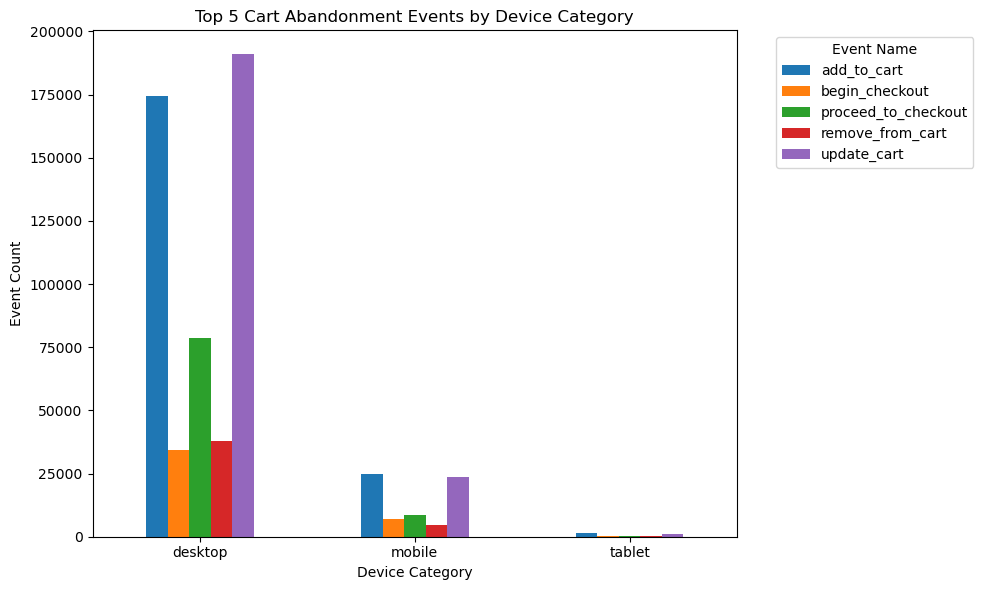

In [77]:
table = (
    google_a[google_a['EVENT_NAME'].isin(important_events)]
    .groupby(['DEVICE_CATEGORY', 'EVENT_NAME'])['EVENT_NAME'].count().reset_index(name='event_count').pivot(index='DEVICE_CATEGORY', columns='EVENT_NAME', values='event_count')
    .fillna(0)
)

table.plot(kind='bar', figsize=(10,6))
plt.title('Top 5 Cart Abandonment Events by Device Category')
plt.xlabel('Device Category')
plt.ylabel('Event Count')
plt.xticks(rotation=0)
plt.legend(title='Event Name', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [78]:
ga_dummies = pd.get_dummies(google_a, columns=['EVENT_NAME', 'DEVICE_CATEGORY', 'DEVICE_MOBILE_BRAND_NAME', 'DEVICE_OPERATING_SYSTEM', 'EVENT_PAGE_NAME'], drop_first=True)

EVENT_NAME  add_to_cart  begin_checkout  proceed_to_checkout  \
WEEKDAY                                                        
Friday            24131            5064                10975   
Monday            49796           11070                22667   
Saturday           7375            1224                 2872   
Sunday            13370            2713                 5621   
Thursday          32075            6511                13836   
Tuesday           38228            8305                16973   
Wednesday         35605            7029                14925   

EVENT_NAME  remove_from_cart  update_cart  
WEEKDAY                                    
Friday                  5258        26502  
Monday                  9780        54417  
Saturday                1690         7340  
Sunday                  2837        14055  
Thursday                7065        33448  
Tuesday                 8231        42447  
Wednesday               7918        37574  


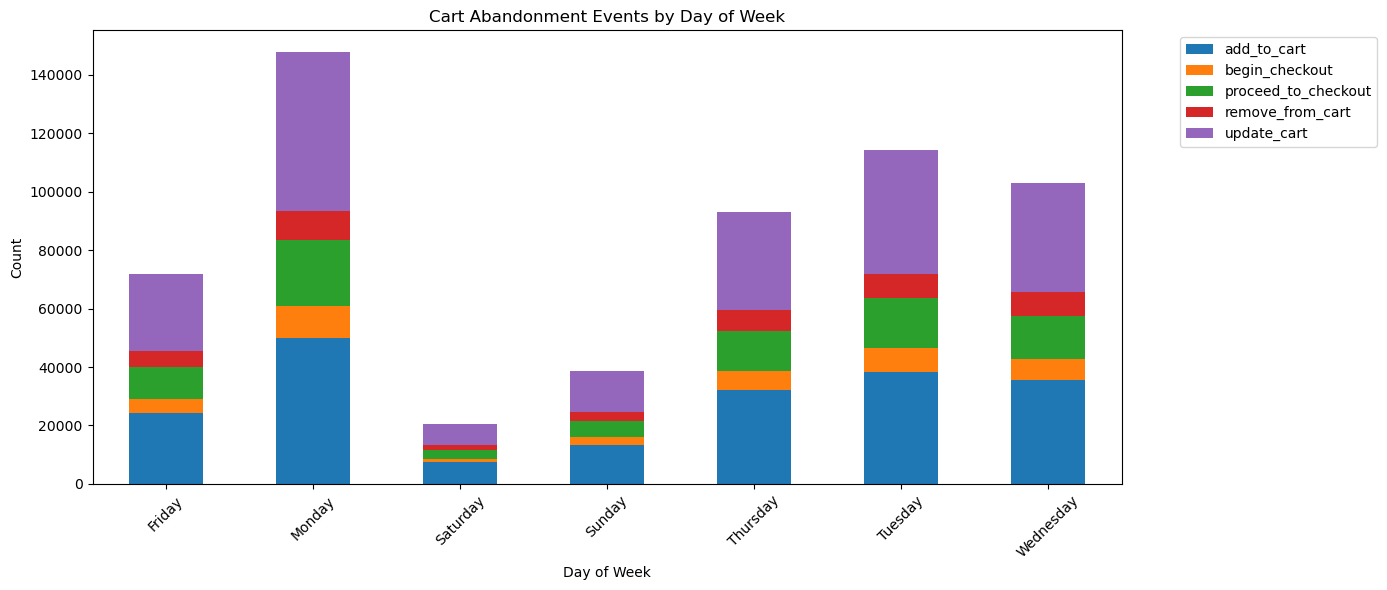

In [79]:
# Extract weekday (0 = Monday, 6 = Sunday)
google_a['WEEKDAY'] = google_a['EVENT_DATE'].dt.day_name()

# Focus only on the cart abandonment events
cart_abandonment_events = ["add_to_cart", "proceed_to_checkout", "remove_from_cart", "update_cart", "begin_checkout"]

# Filter to those events
filtered = google_a[google_a['EVENT_NAME'].isin(cart_abandonment_events)]

# Count by weekday and event
event_counts = (
    filtered
    .groupby(['WEEKDAY','EVENT_NAME'])
    .size()
    .reset_index(name='count')
)

# Pivot for visualization (event types as columns, weekdays as rows)
pivot = event_counts.pivot(index='WEEKDAY', columns='EVENT_NAME', values='count').fillna(0)

print(pivot)

# Plot (stacked bar so you see total volume + breakdown per day)
pivot.plot(kind='bar', stacked=True, figsize=(14,6))
plt.title("Cart Abandonment Events by Day of Week")
plt.ylabel("Count")
plt.xlabel("Day of Week")
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Joining Tables



# -----------------------------
# 4) Use sales as the base table

# 5) Join all customer-key tables except material
# -----------------------------
customer_key_tables = [
    "google_a", "orders", "customer",
    "cutoff", "op_hours", "visit_plan"
]

for tname in customer_key_tables:
    right = sales[tname]
    if "customer_key" not in right.columns:
        continue
    right_pruned = drop_dupe_cols_on_join(base, right, join_keys=["customer_key"])
    base = base.merge(right_pruned, on="customer_key", how="left")

# -----------------------------
# 6) Join material on material_id (or best available key)
# -----------------------------
material_df = dfs["material"].copy()
if "material_id" not in material_df.columns:
    mk = best_material_key(material_df)
    if mk and mk != "material_id":
        material_df = material_df.rename(columns={mk: "material_id"})

base_mat_key = best_material_key(base)
if base_mat_key:
    material_pruned = drop_dupe_cols_on_join(base, material_df, join_keys=["material_id"])
    base = base.merge(material_pruned, left_on=base_mat_key, right_on="material_id", how="left")
    if "material_id_y" in base.columns:  # drop duplicate id from right
        base = base.drop(columns=["material_id_y"]).rename(columns={"material_id_x": "material_id"})
else:
    base["material_id"] = np.nan

# -----------------------------
# 7) Final joined DataFrame
# -----------------------------
joined_df = base

print(joined_df.info())
print(joined_df.head(10))